# Career Foundry 6.6
This exercise will demonstrate 
- How to get data from quandl
- How to perform time series analysis on the data

In [3]:
# import the libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:


In [5]:
# Configure API key 

quandl.ApiConfig.api_key='mFvbqv95DsVENBhAnkyx'

In [7]:
quandl.ApiConfig.api_key

'mFvbqv95DsVENBhAnkyx'

In [9]:
#I'm going to import the data via get_table
data = quandl.get_table('ZILLOW/DATA')


In [11]:
data.head()

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2025-01-31,457847.242831
1,ZSFH,99999,2024-12-31,457250.597887
2,ZSFH,99999,2024-11-30,456891.816779
3,ZSFH,99999,2024-10-31,456998.542716
4,ZSFH,99999,2024-09-30,456517.913569


## Consistency checks

In [17]:
data.shape

(10000, 4)

In [19]:
data.columns

Index(['indicator_id', 'region_id', 'date', 'value'], dtype='object')

In [21]:
type(data)

pandas.core.frame.DataFrame

In [23]:
#I'm going to filter the date before I plot it. There are many regions so I will limit the data to one for the analysis.
data_2 = data[data["region_id"] == "99960"][["date", "value"]]

In [25]:
data_2.head()

,date,value
None,,
9746,2025-01-31,610889.839274
9747,2024-12-31,609044.045685
9748,2024-11-30,606433.642804
9749,2024-10-31,604932.279987
9750,2024-09-30,603553.791183


In [27]:
#reset the index
data_3 = data_2.reset_index(drop=True)

In [29]:
data_3.head()

,date,value
0,2025-01-31,610889.839274
1,2024-12-31,609044.045685
2,2024-11-30,606433.642804
3,2024-10-31,604932.279987
4,2024-09-30,603553.791183


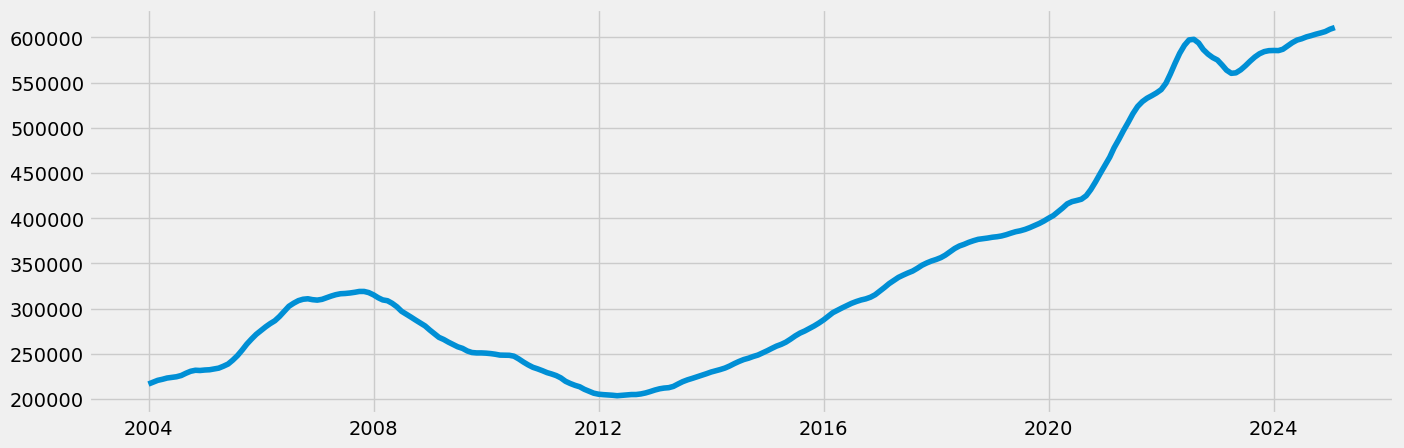

In [31]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot('date', 'value', data=data_3)

In [33]:
#I think I will subset the data. It makes sense to look at the data post-financial crash since this should not impact current housing prices.

In [35]:
data_post_crash = data_3[data_3["date"] >= '1-1-2012'][["date", "value"]]


In [37]:
data_post_crash.head()

,date,value
0,2025-01-31,610889.839274
1,2024-12-31,609044.045685
2,2024-11-30,606433.642804
3,2024-10-31,604932.279987
4,2024-09-30,603553.791183


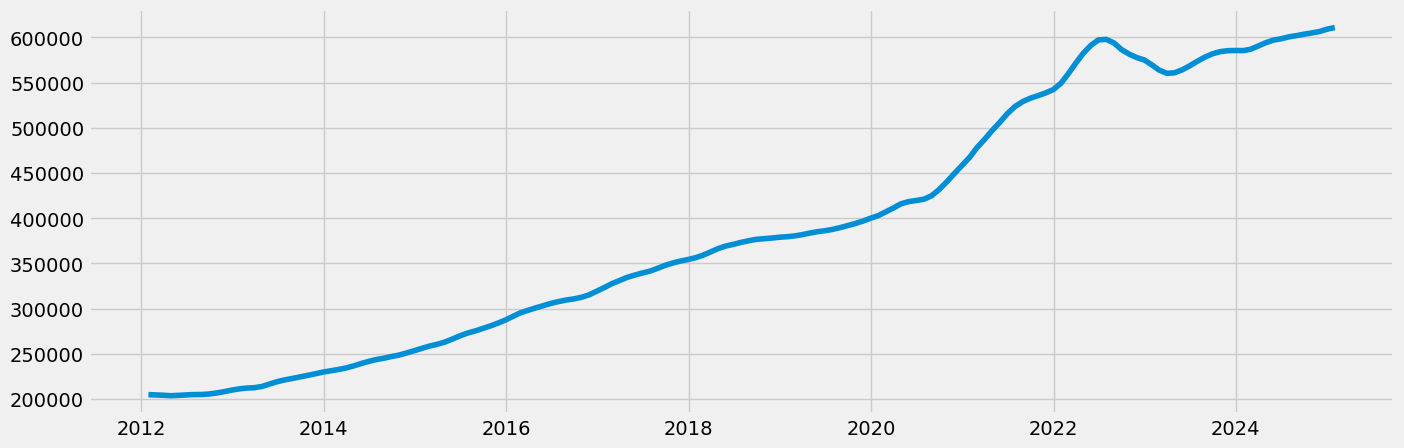

In [39]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot('date', 'value', data=data_post_crash)

In [41]:
#This looks like it forms a much more predictable pattern that is based on current market conditions

## Decompose the data

In [44]:
#reset the index
data_post_crash['date'] = pd.to_datetime(data_post_crash['date']) 
data_post_crash.set_index('date', inplace=True)

In [46]:
decomposition = sm.tsa.seasonal_decompose(data_post_crash, model='additive')

In [48]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

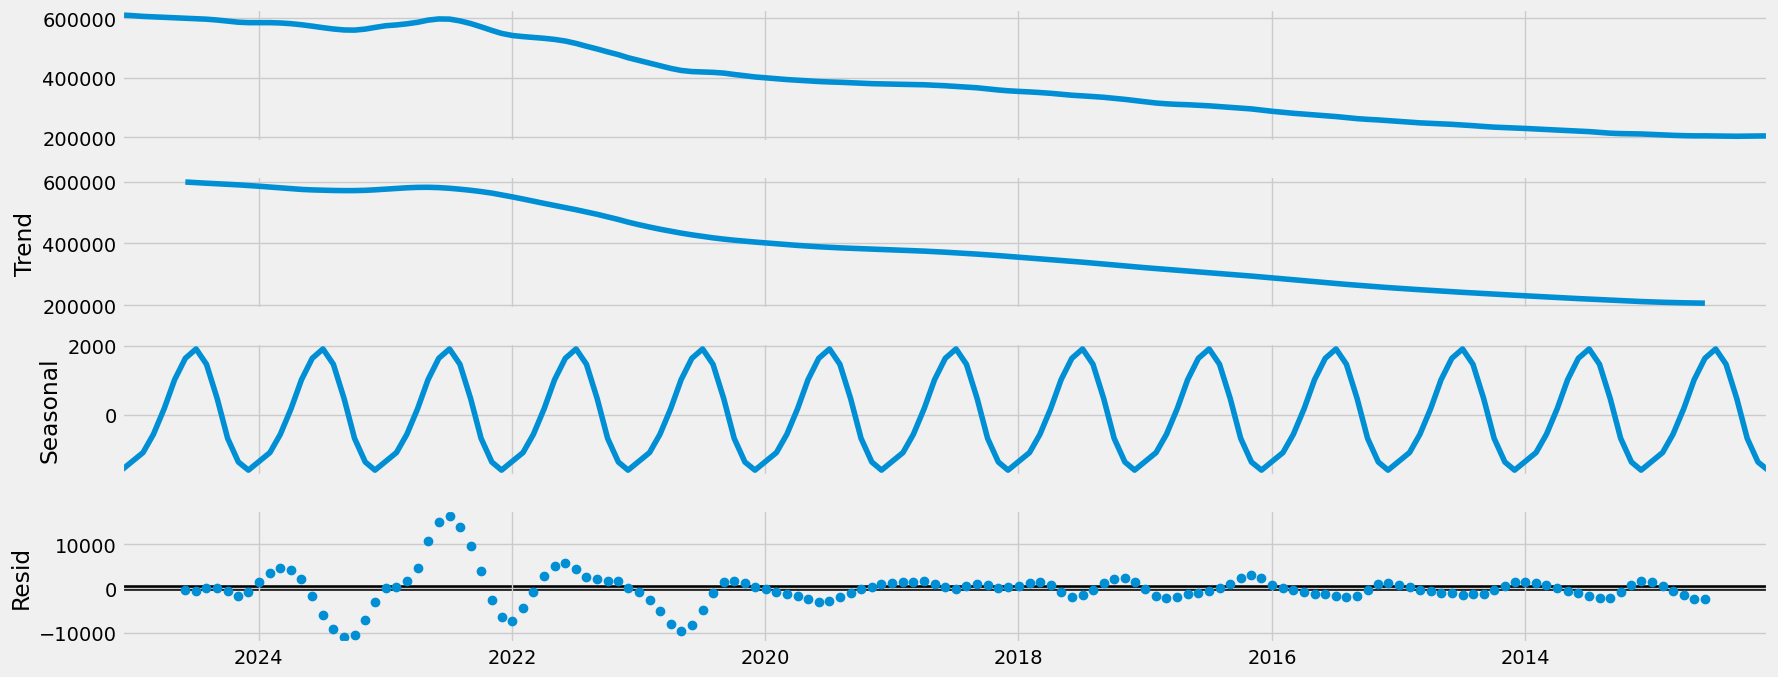

In [50]:
# Plot the separate components

decomposition.plot()
plt.show()

## Analysis
- The second chart in the plot above represents the underlying trend in housing prices. This looks remarkably similar to the first chart which represents the original data. This means that there is very little data that is not explained by the initial trend
- The third chart shows seasonality. With regular intervals, this data does display seasonality. This is not surprising for the housing market tends to have seasonal flxuations.
- The last chart shows how much of the data is not explained by trends or seasonality. Here it is shown that there is very little noise in the data until about 2020. This is when the global pandemic occurred, which ultimately led to increases in interest rates to lower inflation. This is reflected in the increased levels of residuals from 2022 to 2024.

## Check for stationarity

In [53]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function


In [55]:
def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_post_crash['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.370473
p-value                          0.596347
Number of Lags Used             14.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


In [57]:
#since the test statistic is bigger than the critical value of 5% the results are not stationary

In [59]:
#check for autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

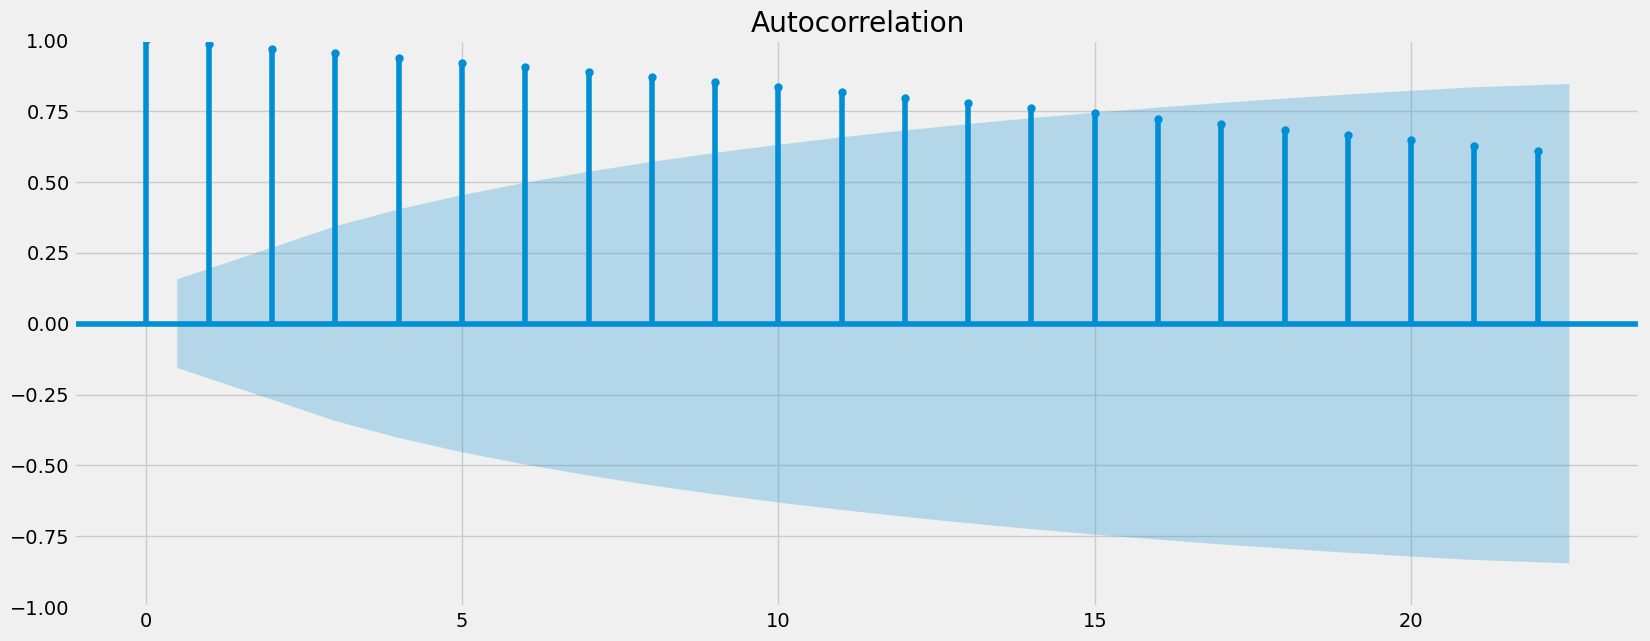

In [61]:
plot_acf(data_post_crash)
plt.show()

In [63]:
#Most of the data is not stationary. The next step is to stationize the Real Estate data

In [65]:
data_diff = data_post_crash - data_post_crash.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [67]:
#drop the missing values that resulted from the state above 
data_diff.dropna(inplace = True)

In [69]:
data_diff.head()

,value
date,
2024-12-31,-1845.793589
2024-11-30,-2610.402881
2024-10-31,-1501.362816
2024-09-30,-1378.488804
2024-08-31,-1577.959516


In [71]:
data_diff.columns

Index(['value'], dtype='object')

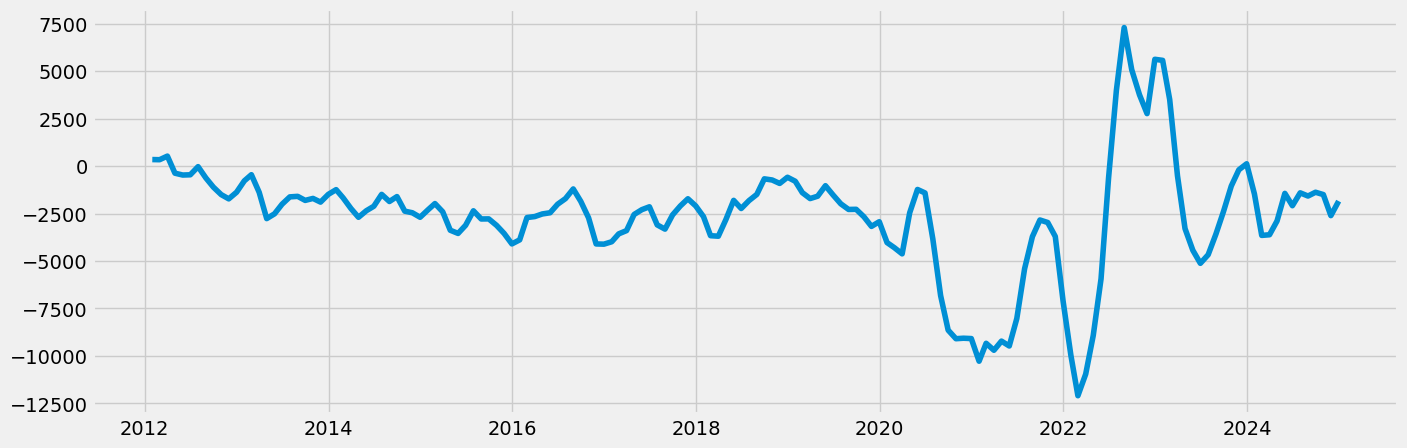

In [73]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [75]:
#perform dicky fuller again
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.514601
p-value                          0.111962
Number of Lags Used             14.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64


In [87]:
#the test statistic is just above the critical value, t

In [89]:
# shift the data one additional time
data_diff_2 = data_diff - data_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [91]:
#drop the missing values that resulted from the state above 
data_diff_2.dropna(inplace = True)

In [93]:
data_diff_2.head()

,value
date,
2024-11-30,-764.609292
2024-10-31,1109.040065
2024-09-30,122.874012
2024-08-31,-199.470712
2024-07-31,168.149422


In [95]:
data_diff_2.columns

Index(['value'], dtype='object')

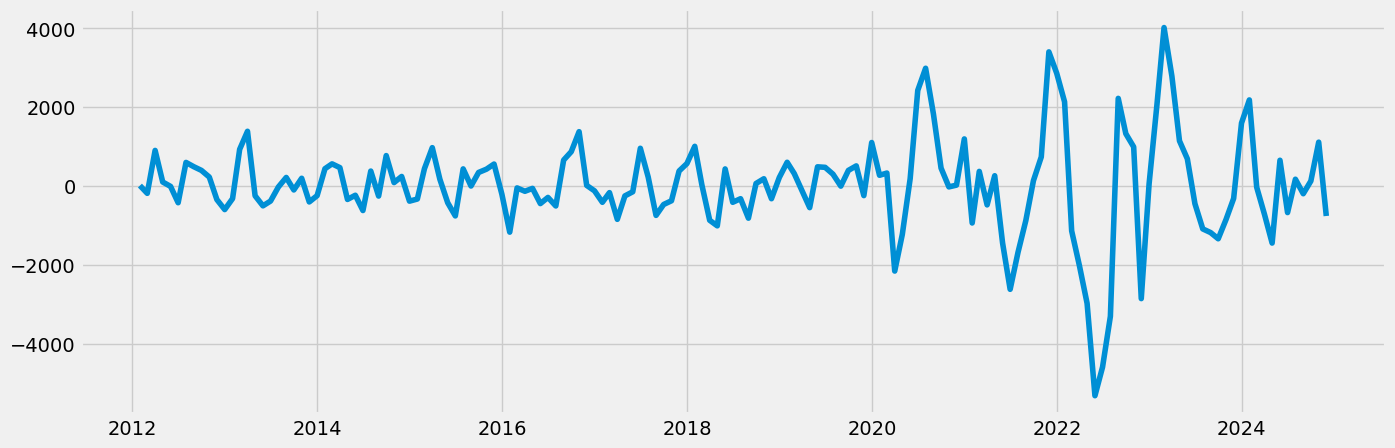

In [97]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [99]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.481692
p-value                          0.008470
Number of Lags Used             13.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64


In [101]:
#this time the test statistic is smaller than the critical value. The data is stationary

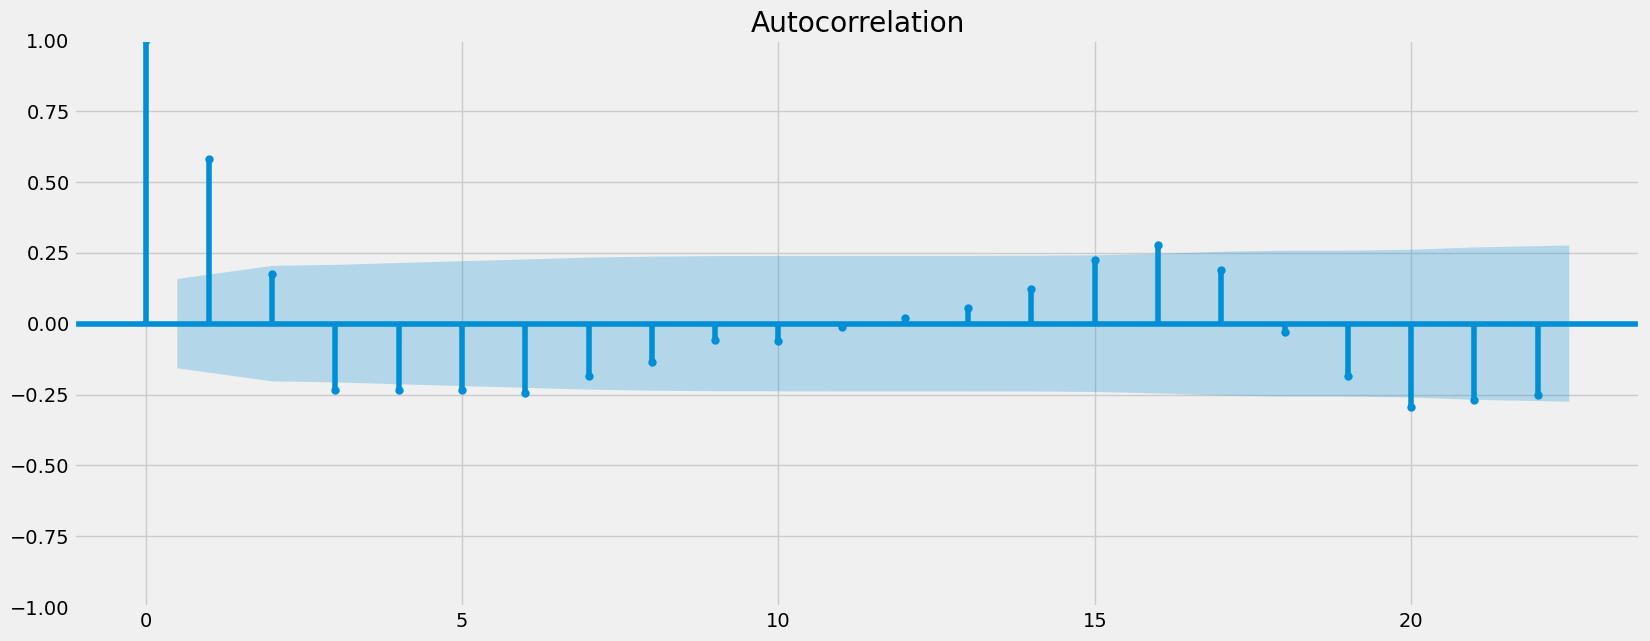

In [103]:
#check again for auto correlation 
plot_acf(data_diff_2)
plt.show()

In [105]:
#the data shows significantly less auto correlation than the original chart